# MERRA2 Comparisons
1. Direct temperature comparison (M2.S1)
2. Variance (M2.S2)
3. Autocorrelation (M2.S3)

In [1]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=80>

In [2]:
INPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/MERRA2/SIM_VARIABLES/"
tmin_merra2_ds = xarray.open_zarr(f"{INPUT_DIR}MERRA2_day_T2MMIN.zarr")["T2MMIN"].sel(time=slice("1980-01-03T12:00:00.000000000","2023-12-31T12:00:00.000000000"))

start = cftime.DatetimeNoLeap(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True)
end = cftime.DatetimeNoLeap(2023, 12, 31, 0, 0, 0, 0, has_year_zero=True)
INPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/"
tmin_CESM1_ds = xarray.open_zarr(f"{INPUT_DIR}all_day_TREFHTMN.zarr")["TREFHTMN"].sel(member="001").sel(time=slice(start, end))
tmin_CESM1_ds = tmin_CESM1_ds.assign_coords(dict(lon=(tmin_CESM1_ds.lon + 180) % 360 - 180)).sortby("lon")


m, b = np.polyfit(np.arange(tmin_merra2_ds.time.size), tmin_merra2_ds.mean(dim=["lat", "lon"]).values, deg=1)
merra2_trend = xarray.DataArray(
    m*np.arange(tmin_merra2_ds.time.size) + b,
    coords=dict(time=tmin_merra2_ds.time.values)
)

m, b = np.polyfit(np.arange(tmin_CESM1_ds.time.size), tmin_CESM1_ds.mean(dim=["lat", "lon"]).values, deg=1)
CESM1_trend = xarray.DataArray(
    m*np.arange(tmin_CESM1_ds.time.size) + b,
    coords=dict(time=tmin_CESM1_ds.time.values)
)

merra2_detrended = tmin_merra2_ds - merra2_trend
CESM1_detrended = tmin_CESM1_ds - CESM1_trend

merra2_variance = merra2_detrended.var(dim="time").compute()
CESM1_variance = CESM1_detrended.var(dim="time").compute()

merra2_autocorr = xarray.corr(merra2_detrended, merra2_detrended.shift(time=1), dim="time").compute()
CESM1_autocorr = xarray.corr(CESM1_detrended, CESM1_detrended.shift(time=1), dim="time").compute()

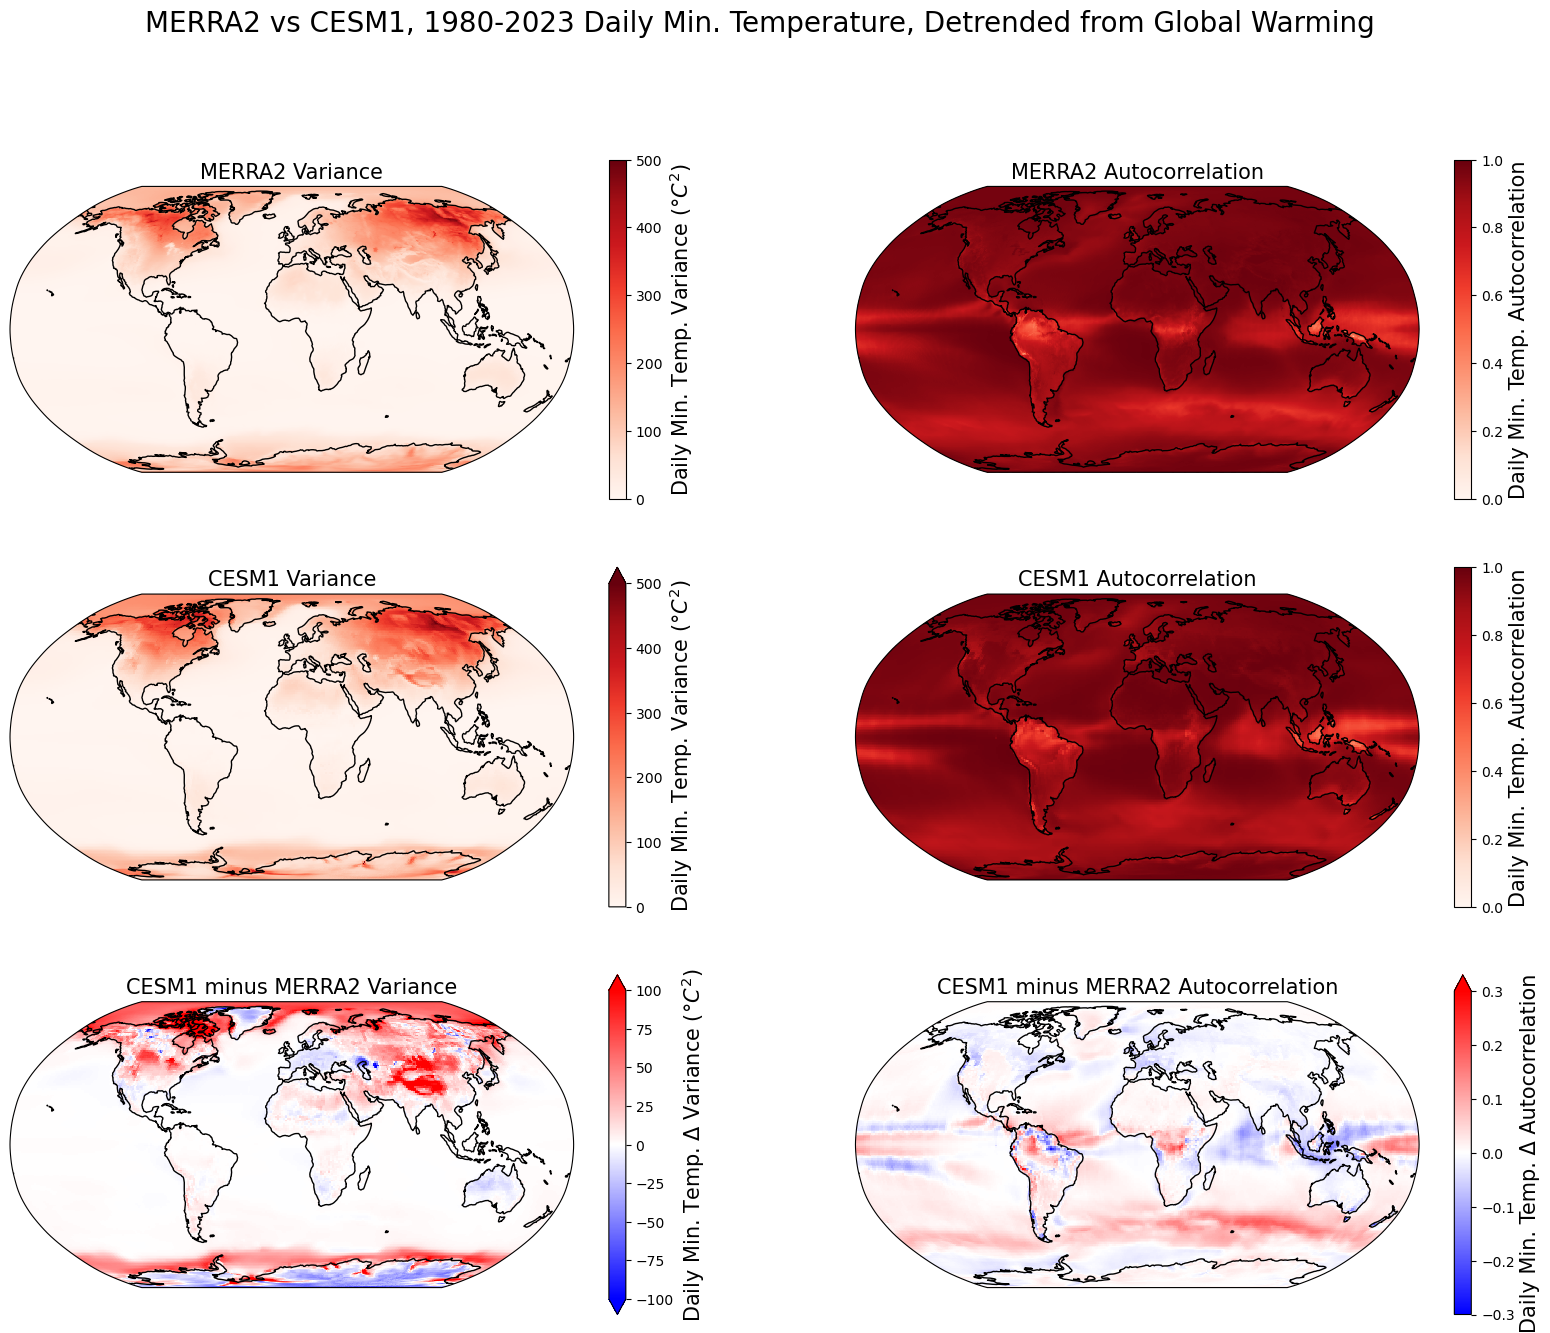

In [3]:
proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 15), facecolor='w', subplot_kw=dict(projection=proj))

cmap = "Reds"
vmin = 0
vmax = 50

# , vmax=vmax, vmin=vmin
cb1 = merra2_variance.plot(ax=ax1, vmax=500, vmin=0, cmap=cmap, transform=transform)
cb2 = merra2_autocorr.plot(ax=ax2, vmax=1, vmin=0, cmap=cmap, transform=transform)

cb3 = CESM1_variance.plot(ax=ax3, vmax=500, vmin=0, cmap=cmap, transform=transform)
cb4 = CESM1_autocorr.plot(ax=ax4, vmax=1, vmin=0, cmap=cmap, transform=transform)

cmap = "bwr"
cb5 = (CESM1_variance - merra2_variance.interp(lat=CESM1_variance.lat,lon=CESM1_variance.lon)).plot(ax=ax5, cmap=cmap, transform=transform, vmax=100, vmin=-100)
cb6 = (CESM1_autocorr - merra2_autocorr.interp(lat=CESM1_autocorr.lat,lon=CESM1_autocorr.lon)).plot(ax=ax6, cmap=cmap, transform=transform, vmax=0.3, vmin=-0.3)


fz = 15
ax1.set_title("MERRA2 Variance", fontsize=fz)
ax2.set_title("MERRA2 Autocorrelation", fontsize=fz)
ax3.set_title("CESM1 Variance", fontsize=fz)
ax4.set_title("CESM1 Autocorrelation", fontsize=fz)

cb1.colorbar.set_label("Daily Min. Temp. Variance (°$C^2$)", fontsize=fz)
cb2.colorbar.set_label("Daily Min. Temp. Autocorrelation", fontsize=fz)
cb3.colorbar.set_label("Daily Min. Temp. Variance (°$C^2$)", fontsize=fz)
cb4.colorbar.set_label("Daily Min. Temp. Autocorrelation", fontsize=fz)
cb5.colorbar.set_label("Daily Min. Temp. Δ Variance (°$C^2$)", fontsize=fz)
cb6.colorbar.set_label("Daily Min. Temp. Δ Autocorrelation", fontsize=fz)

ax5.set_title("CESM1 minus MERRA2 Variance", fontsize=fz)
ax6.set_title("CESM1 minus MERRA2 Autocorrelation", fontsize=fz)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
ax6.coastlines()

f.suptitle("MERRA2 vs CESM1, 1980-2023 Daily Min. Temperature, Detrended from Global Warming", fontsize=20)

f.show()

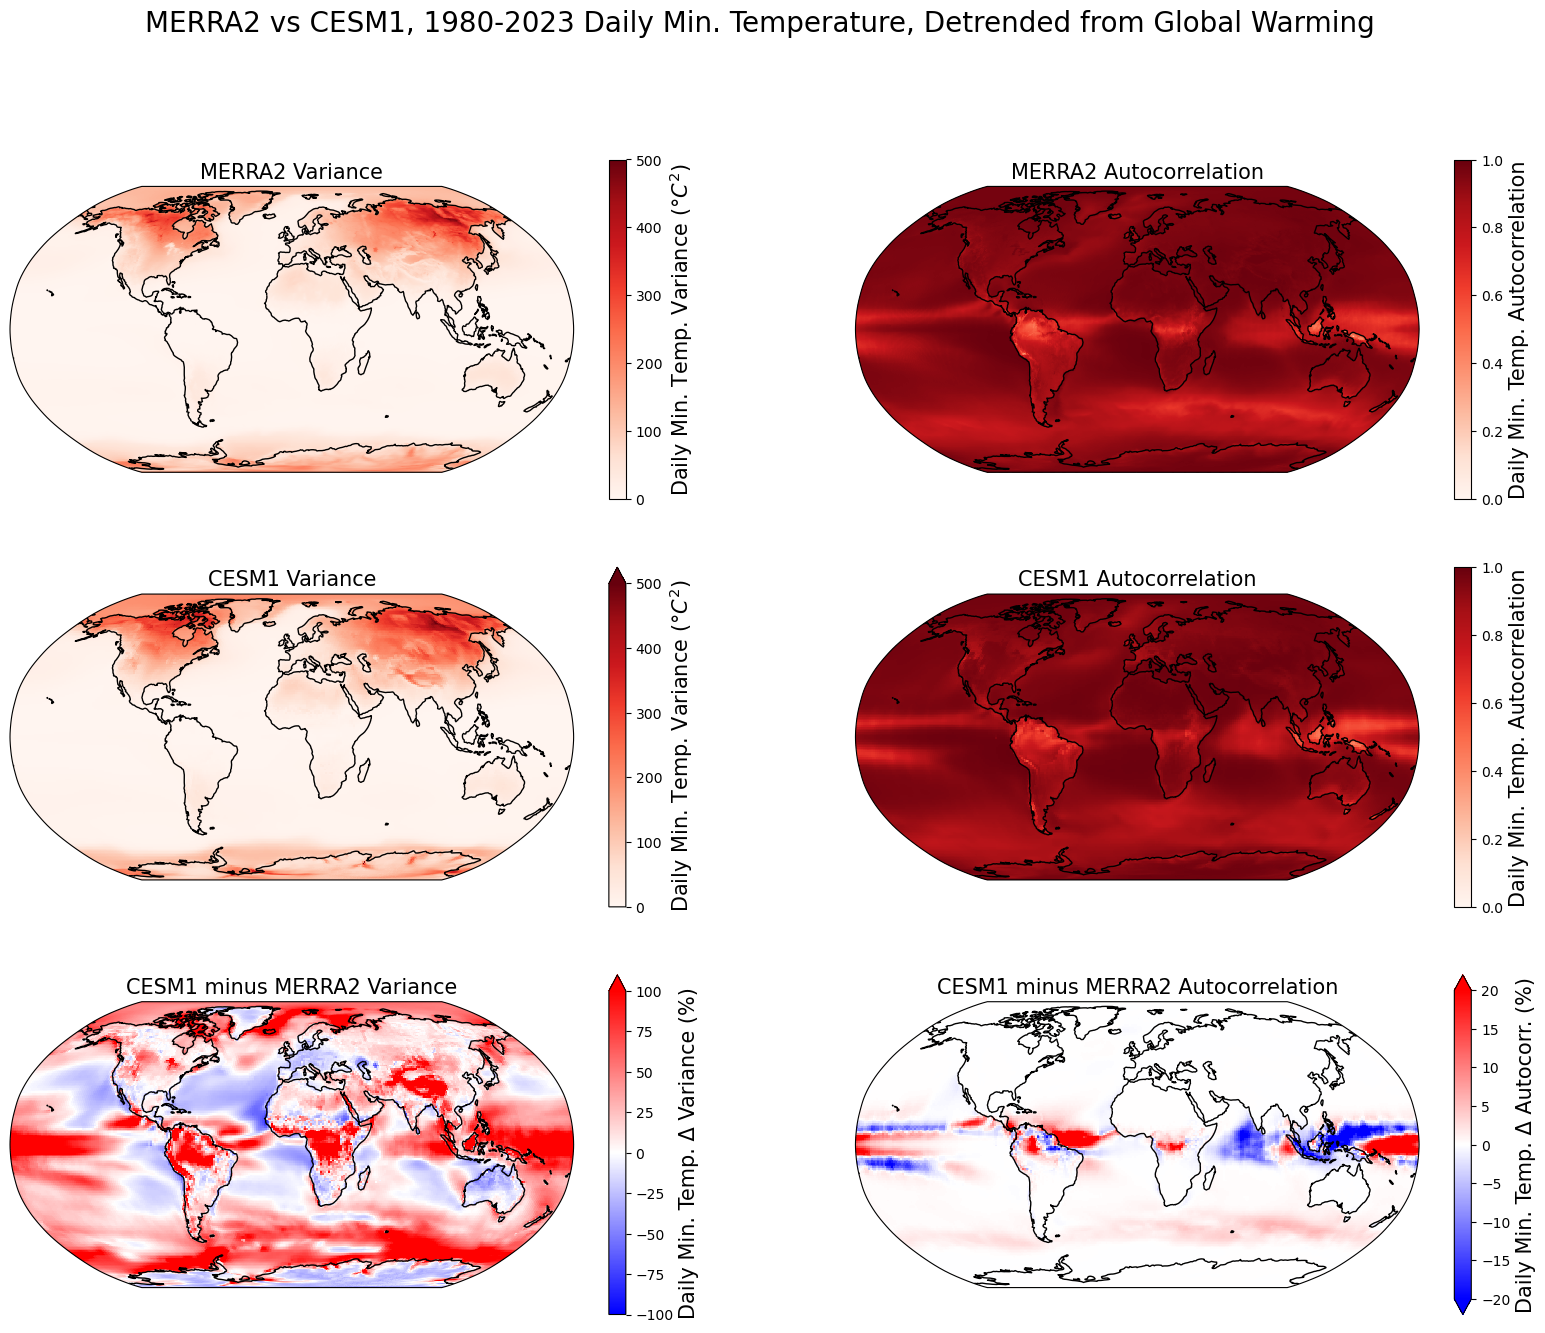

In [4]:
proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 15), facecolor='w', subplot_kw=dict(projection=proj))

cmap = "Reds"
vmin = 0
vmax = 50

# , vmax=vmax, vmin=vmin
cb1 = merra2_variance.plot(ax=ax1, vmax=500, vmin=0, cmap=cmap, transform=transform)
cb2 = merra2_autocorr.plot(ax=ax2, vmax=1, vmin=0, cmap=cmap, transform=transform)

cb3 = CESM1_variance.plot(ax=ax3, vmax=500, vmin=0, cmap=cmap, transform=transform)
cb4 = CESM1_autocorr.plot(ax=ax4, vmax=1, vmin=0, cmap=cmap, transform=transform)

cmap = "bwr"
merra_var_interp = merra2_variance.interp(lat=CESM1_variance.lat,lon=CESM1_variance.lon)
merra_ac_interp = merra2_autocorr.interp(lat=CESM1_autocorr.lat,lon=CESM1_autocorr.lon)
cb5 = (100*(CESM1_variance - merra_var_interp) / merra_var_interp).plot(ax=ax5, cmap=cmap, transform=transform, vmax=100, vmin=-100)
cb6 = (100*(CESM1_autocorr - merra_ac_interp) / merra_var_interp).plot(ax=ax6, cmap=cmap, transform=transform, vmax=20, vmin=-20)


fz = 15
ax1.set_title("MERRA2 Variance", fontsize=fz)
ax2.set_title("MERRA2 Autocorrelation", fontsize=fz)
ax3.set_title("CESM1 Variance", fontsize=fz)
ax4.set_title("CESM1 Autocorrelation", fontsize=fz)

cb1.colorbar.set_label("Daily Min. Temp. Variance (°$C^2$)", fontsize=fz)
cb2.colorbar.set_label("Daily Min. Temp. Autocorrelation", fontsize=fz)
cb3.colorbar.set_label("Daily Min. Temp. Variance (°$C^2$)", fontsize=fz)
cb4.colorbar.set_label("Daily Min. Temp. Autocorrelation", fontsize=fz)
cb5.colorbar.set_label("Daily Min. Temp. Δ Variance (%)", fontsize=fz)
cb6.colorbar.set_label("Daily Min. Temp. Δ Autocorr. (%)", fontsize=fz)

ax5.set_title("CESM1 minus MERRA2 Variance", fontsize=fz)
ax6.set_title("CESM1 minus MERRA2 Autocorrelation", fontsize=fz)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
ax6.coastlines()

f.suptitle("MERRA2 vs CESM1, 1980-2023 Daily Min. Temperature, Detrended from Global Warming", fontsize=20)

f.show()